In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.8.5
Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


In [2]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/1.0.0. Subsequent calls will reuse this data.


In [3]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

get_label_name = dataset_info.features['label'].int2str

def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())
        
        

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3
Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [4]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label


dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())



Label: 2 

Image shape: (150, 150, 3) 

[[[0.9941176  0.9941176  0.9941176 ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9764706  0.9764706  0.9764706 ]
  [0.97745097 0.97745097 0.97745097]
  [0.972549   0.972549   0.972549  ]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9813726  0.9813726  0.9813726 ]
  [0.9764706  0.9764706  0.9764706 ]
  [0.97745097 0.97745097 0.97745097]]

 [[0.99705887 0.99705887 0.99705887]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9794117  0.9794117  0.9794117 ]
  [0.9754902  0.9754902  0.9754902 ]
  [0.97450984 0.97450984 0.97450984]]

 ...

 [[0.98725486 0.98725486 0.98725486]
  [0.9862745  0.9862745  0.9862745 ]
  [0.9911765  0.9911765  0.9911765 ]
  ...
  [0.97745097 0.97745097 0.97745097]
  [0.9794117  0.9794117  0.9794117 ]
  [0.97843134 0.97843134 0.97843134]]

 [[0.9901961  0.9901961  0.9901961

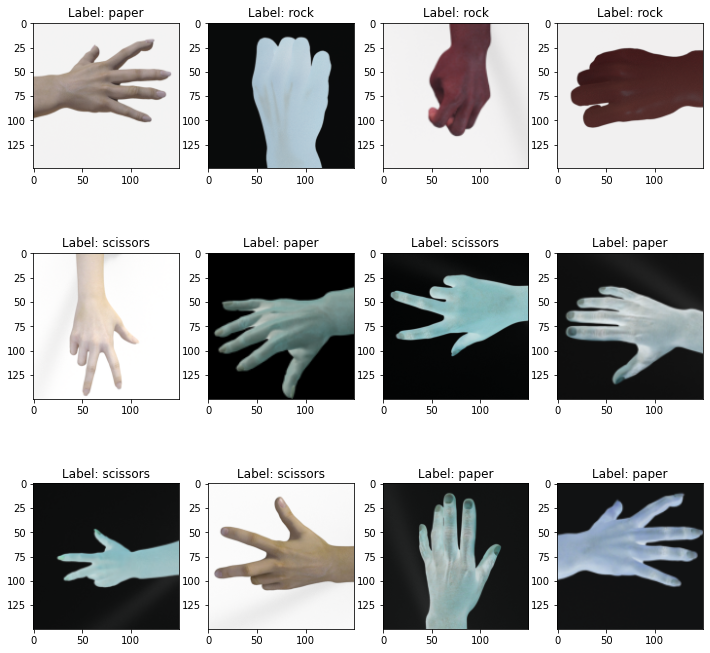

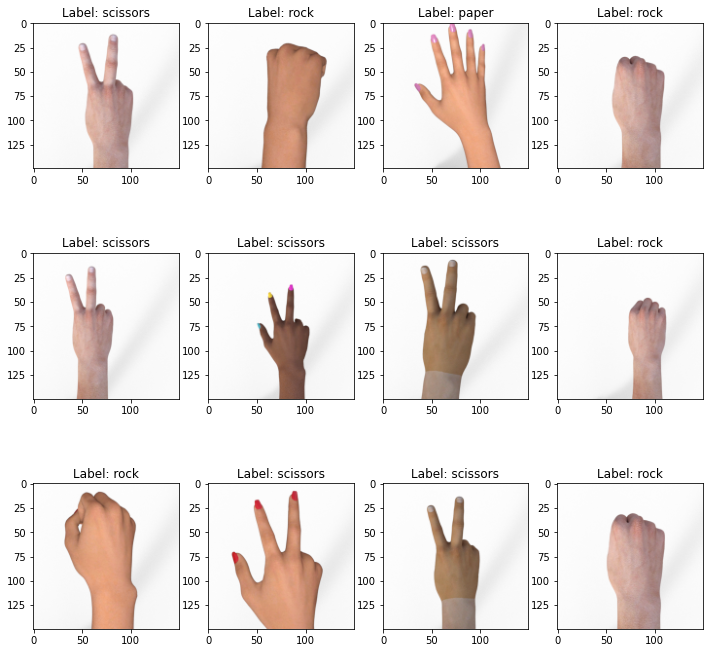

In [5]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

dataset_train_augmented = dataset_train.map(augment_data)

preview_dataset(dataset_train_augmented)

preview_dataset(dataset_test)

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>
Label batch shape: (32,) 

Image batch shape: (32, 150, 150, 3) 

Label batch: [0 1 0 1 1 2 2 2 2 1 1 1 2 2 0 2 0 0 0 0 0 2 0 1 1 2 1 1 0 0 1 0] 

First batch image: [[[0.9672024  0.9669678  0.96669114]
  [0.9691408  0.96890616 0.9686295 ]
  [0.9691408  0.96890616 0.9686295 ]
  ...
  [0.9759252  0.9756906  0.9754139 ]
  [0.9768944  0.9766598  0.9763831 ]
  [0.9788328  0.9785981  0.97832143]]

 [[0.9730177  0.972783   0.97250634]
  [0.9691408  0.96890616 0.9686295 ]
  [0.9691408  0.96890616 0.9686295 ]
  ...
  [0.9768944  0.9766598  0.9763831 ]
  [0.97786355 0.97762895 0.97735226]
  [0.979802   0.97956735 0.97929066]]

 [[0.9710792  0.9708445  0.9705679 ]
  [0.97011    0.96987534 0.96959865]
  [0.9691408  0.96890616 0.9686295 ]
  ...
  [0.97495604 0.9747214  0.97444475]
  [0.9759252  0.9756906  0.9754139 ]
  [0.97786

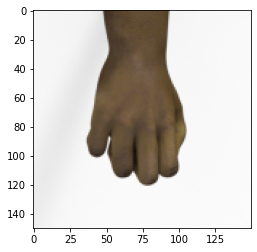

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [6]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break
    
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=INPUT_IMG_SHAPE,
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Second convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Third convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Fourth convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

steps_per_epoch: 78
validation_steps: 11
Epoch 1/15
78/78 [==============================] - 43s 550ms/step - loss: 1.2145 - accuracy: 0.4307 - val_loss: 1.0591 - val_accuracy: 0.6449
Epoch 2/15
78/78 [==============================] - 42s 536ms/step - loss: 0.7181 - accuracy: 0.6961 - val_loss: 0.5261 - val_accuracy: 0.8267
Epoch 3/15
78/78 [==============================] - 42s 533ms/step - loss: 0.4478 - accuracy: 0.8244 - val_loss: 0.5618 - val_accuracy: 0.7074
Epoch 4/15
78/78 [==============================] - 42s 539ms/step - loss: 0.3566 - accuracy: 0.8682 - val_loss: 0.4401 - val_accuracy: 0.7841
Epoch 5/15
78/78 [==============================] - 42s 540ms/step - loss: 0.2306 - accuracy: 0.9252 - val_loss: 0.2999 - val_accuracy: 0.8864
Epoch 6/15
78/78 [==============================] - 42s 544ms/step - loss: 0.2324 - accuracy: 0.9212 - val_loss: 0.3947 - val_accuracy: 0.7756
Epoch 7/15
78/78 [==============================] - 41s 531ms/step - loss: 0.1678 - accuracy: 0.9453 